In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("LSTM-Multivariate_pollution.csv")
df.head()

,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       43800 non-null  object 
 1   pollution  43800 non-null  float64
 2   dew        43800 non-null  int64  
 3   temp       43800 non-null  float64
 4   press      43800 non-null  float64
 5   wnd_dir    43800 non-null  object 
 6   wnd_spd    43800 non-null  float64
 7   snow       43800 non-null  int64  
 8   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 3.0+ MB


In [4]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Display the summary of missing values
missing_values


date         0
pollution    0
dew          0
temp         0
press        0
wnd_dir      0
wnd_spd      0
snow         0
rain         0
dtype: int64

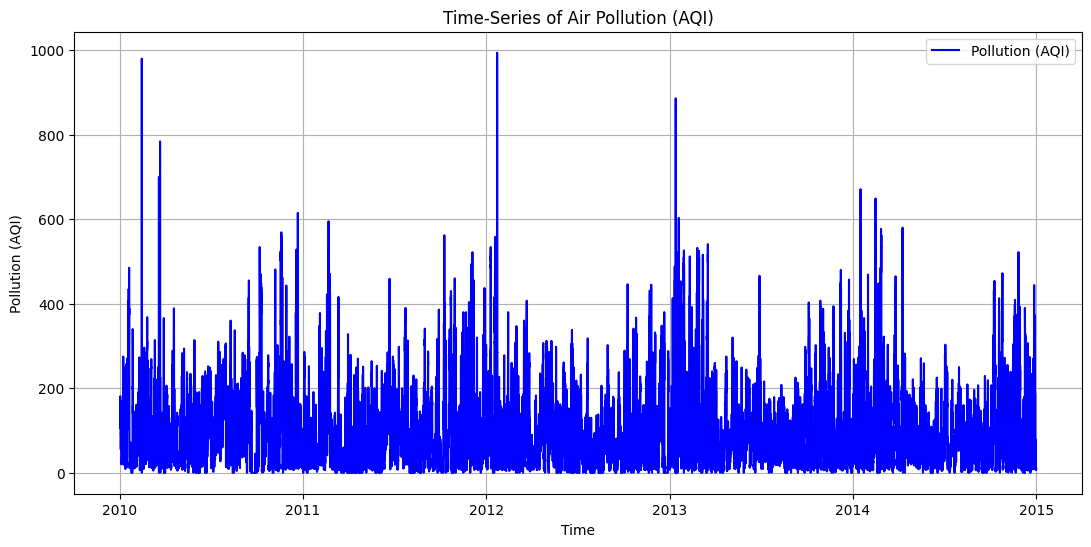

In [5]:
import matplotlib.pyplot as plt

# Set 'date' as the index for easier time-series visualization
df.set_index('date', inplace=True)

# Plot the pollution data over time
plt.figure(figsize=(13, 6))
plt.plot(df['pollution'], color='blue', label='Pollution (AQI)')
plt.title('Time-Series of Air Pollution (AQI)')
plt.xlabel('Time')
plt.ylabel('Pollution (AQI)')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
! pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable


<Figure size 1400x1000 with 0 Axes>

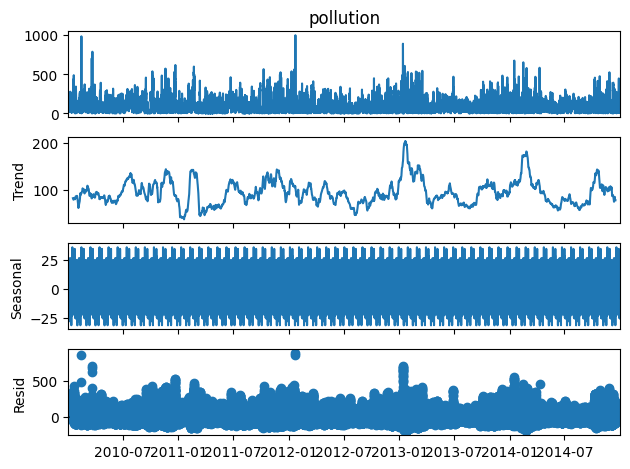

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time-series data for pollution
decomposition = seasonal_decompose(df['pollution'], model='additive', period=24*30)  # Assuming daily seasonality

# Plot the decomposed components
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.tight_layout()
plt.show()


In [8]:
# Feature Engineering: Adding time-based and rolling statistics features

# Resetting the index to preserve the 'date' column for feature extraction
df.reset_index(inplace=True)

# Extracting date-time features
df['hour'] = df['date'].dt.hour
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday

# Adding rolling statistics for the pollution variable
df['pollution_rolling_mean_24h'] = df['pollution'].rolling(window=24).mean()  # 24-hour rolling mean
df['pollution_rolling_std_24h'] = df['pollution'].rolling(window=24).std()   # 24-hour rolling std

# Adding lag features (e.g., pollution levels from the past 1, 6, and 24 hours)
df['pollution_lag_1h'] = df['pollution'].shift(1)    # 1-hour lag
df['pollution_lag_6h'] = df['pollution'].shift(6)    # 6-hour lag
df['pollution_lag_24h'] = df['pollution'].shift(24)  # 24-hour lag

# Displaying the first few rows of the updated dataset
df.head()


,date,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,hour,day,month,weekday,pollution_rolling_mean_24h,pollution_rolling_std_24h,pollution_lag_1h,pollution_lag_6h,pollution_lag_24h
0,2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0,0,2,1,5,NaN,NaN,NaN,NaN,NaN
1,2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0,1,2,1,5,NaN,NaN,129.0,NaN,NaN
2,2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2,2,1,5,NaN,NaN,148.0,NaN,NaN
3,2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0,3,2,1,5,NaN,NaN,159.0,NaN,NaN
4,2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0,4,2,1,5,NaN,NaN,181.0,NaN,NaN


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Drop rows with NaN values introduced by rolling and lag features
df_cleaned = df.dropna()

# Define target variable (pollution) and features
target = df_cleaned['pollution']
features = df_cleaned[
    ['hour', 'day', 'month', 'weekday', 'pollution_rolling_mean_24h',
     'pollution_rolling_std_24h', 'pollution_lag_1h', 'pollution_lag_6h', 'pollution_lag_24h']
]

# Scale features using MinMaxScaler
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

# Reshape target for consistency
target = target.values.reshape(-1, 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42, shuffle=False)

# Prepare data for LSTM: Reshape inputs into [samples, time steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Summary of shapes for modeling
X_train_lstm.shape, X_test_lstm.shape, y_train.shape, y_test.shape


((35020, 1, 9), (8756, 1, 9), (35020, 1), (8756, 1))

Epoch 1/100, Train Loss: 17163.63671875, Val Loss: 18103.10546875
Epoch 2/100, Train Loss: 17162.037109375, Val Loss: 18101.431640625
Epoch 3/100, Train Loss: 17160.421875, Val Loss: 18099.734375
Epoch 4/100, Train Loss: 17158.78125, Val Loss: 18098.001953125
Epoch 5/100, Train Loss: 17157.11328125, Val Loss: 18096.21875
Epoch 6/100, Train Loss: 17155.3984375, Val Loss: 18094.375
Epoch 7/100, Train Loss: 17153.615234375, Val Loss: 18092.4609375
Epoch 8/100, Train Loss: 17151.767578125, Val Loss: 18090.458984375
Epoch 9/100, Train Loss: 17149.83984375, Val Loss: 18088.365234375
Epoch 10/100, Train Loss: 17147.822265625, Val Loss: 18086.166015625
Epoch 11/100, Train Loss: 17145.701171875, Val Loss: 18083.84765625
Epoch 12/100, Train Loss: 17143.46484375, Val Loss: 18081.3984375
Epoch 13/100, Train Loss: 17141.115234375, Val Loss: 18078.806640625
Epoch 14/100, Train Loss: 17138.607421875, Val Loss: 18076.052734375
Epoch 15/100, Train Loss: 17135.955078125, Val Loss: 18073.125
Epoch 16/100

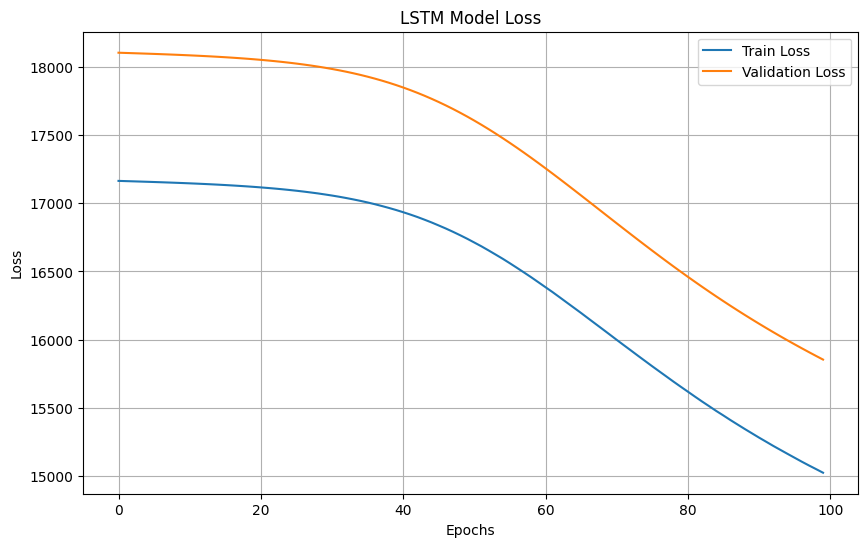

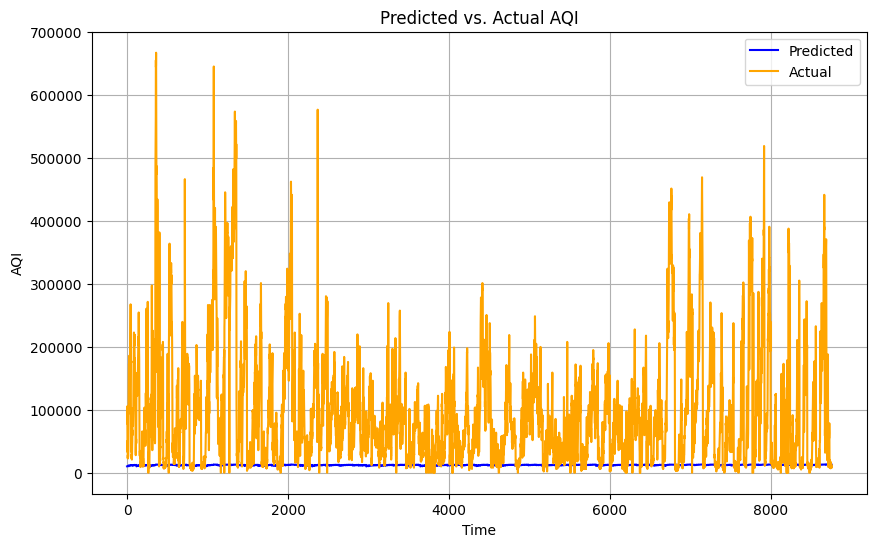

RMSE: 125156.2265625
MAE: 84865.7578125


In [32]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

# Define the LSTM model with dropout and more layers
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, num_layers=2, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Use the output from the last time step
        return out

# Hyperparameters
input_size = X_train_lstm.shape[2]
hidden_size = 100  # Increased hidden size
output_size = 1
learning_rate = 0.001
epochs = 100  # Increased epochs for more training
dropout_prob = 0.3  # Dropout regularization

# Initialize model, loss function, and optimizer
model = LSTMModel(input_size, hidden_size, output_size, dropout_prob)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Training loop
train_losses, val_losses = [], []
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor)
        val_loss = criterion(val_outputs, y_test_tensor)
        val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}")

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Inverse transform predictions and actual values
predictions = target_scaler.inverse_transform(model(X_test_tensor).detach().numpy())
actuals = target_scaler.inverse_transform(y_test_tensor.numpy().reshape(-1, 1))

# Plot Predicted vs Actual AQI
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predicted', color='blue')
plt.plot(actuals, label='Actual', color='orange')
plt.title('Predicted vs. Actual AQI')
plt.xlabel('Time')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE and MAE
rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
mae = np.mean(np.abs(predictions - actuals))

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
